In [1]:
using Revise
using DrWatson

In [2]:
@quickactivate :ReactiveMPPaperExperiments

In [3]:
using CairoMakie # Plots related stuff
using Turing, MCMCChains, Distributions, LinearAlgebra, Random # Bayesian Inference packages
using BenchmarkTools, DataFrames, Query # Analysis tools

import ReactiveMP # For collect_results

In this section we want to compare results and performance of ReactiveMP.jl with another probabilistic programming library which is called Turing.jl. Turing is a general probabilistic programming toolbox and does not use message passing for inference procedure, but sampling. Message passing has an advantage over sampling approach for conjugate models (which our hidden markov model is) because it may fallback to analytically tractable update rules, where sampling cannot. 

### Data

In [4]:
params = let
    # Seed for reproducability
    seed = 123
    
    # Number of samples in dataset
    n = 50
    
    # Transition probabilities (some transitions are impossible)
    A = [0.9 0.0 0.1; 0.1 0.9 0.0; 0.0 0.1 0.9]
    
    # Observation noise
    B = [0.0 0.05 0.9; 0.05 0.9 0.05; 0.9 0.05 0.05] 
    
    @strdict seed n A B
end;

In [5]:
z, y = generate_data(HMMModel(), params);

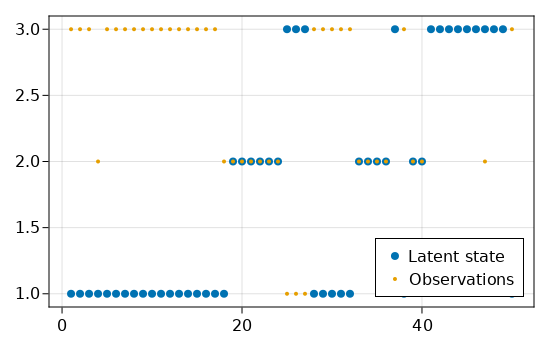

In [6]:
let 
    fig = Figure(resolution = (550, 350))
    ax  = Axis(fig[1, 1])
    
    range = 1:length(z)
    
    scatter!(ax, range, argmax.(z), markersize = 8, label = "Latent state")
    scatter!(ax, range, argmax.(y), markersize = 4, label = "Observations")
    
    axislegend(ax, position = :rb)
    
    fig
end

### Model specification

In [7]:
normalise(x) = x ./ sum(x)

normalise (generic function with 1 method)

In [8]:
@model BayesHmm(y, K) = begin
    # Get observation length.
    N = length(y)

    # State sequence.
    z = Turing.tzeros(Int, N)

    # Transition matrix.
    A = Vector{Vector}(undef, K)

    # Observations model matrix.
    B = Vector{Vector}(undef, K)

    # Assign distributions to each element of the transition matrix and the
    # emission matrix.
    for i = 1:K
        A_c_prior = normalise(ones(K))
        B_c_prior = ones(K)
        B_c_prior[K - i + 1] = 10.0
        B_c_prior = normalise(B_c_prior)
        
        A[i] ~ Dirichlet(A_c_prior)
        B[i] ~ Dirichlet(B_c_prior)
    end

    # Observe each point of the input.
    z[1] ~ Categorical(K)
    y[1] ~ Categorical(vec(B[z[1]]))

    for i = 2:N
        z[i] ~ Categorical(vec(A[z[i - 1]]))
        y[i] ~ Categorical(vec(B[z[i]]))
    end
end;

### Inference

In [9]:
function inference_turing(observations; nsamples = 500, seed = 42)
    rng     = MersenneTwister(seed)
    sampler = Turing.Gibbs(Turing.HMC(0.1, 20, :A, :B), Turing.PG(40, :z))
    return Turing.sample(rng, BayesHmm(observations, 3), sampler, nsamples)
end

inference_turing (generic function with 1 method)

In [10]:
z_turing_estimated = inference_turing(argmax.(y));

Sampling: 100%|█████████████████████████████████████████| Time: 0:03:10


In [11]:
println("Average MSE: $(average_mse(z, z_turing_estimated, :z, Categorical))")

Average MSE: 3.983999999999998


In [12]:
summary = Turing.summarize(z_turing_estimated, Turing.mean, Turing.std);

In [13]:
turing_z_means = map(i -> summary[Symbol("z[$i]")].nt.mean |> first, 1:length(z))
turing_z_stds = map(i -> summary[Symbol("z[$i]")].nt.std |> first, 1:length(z));

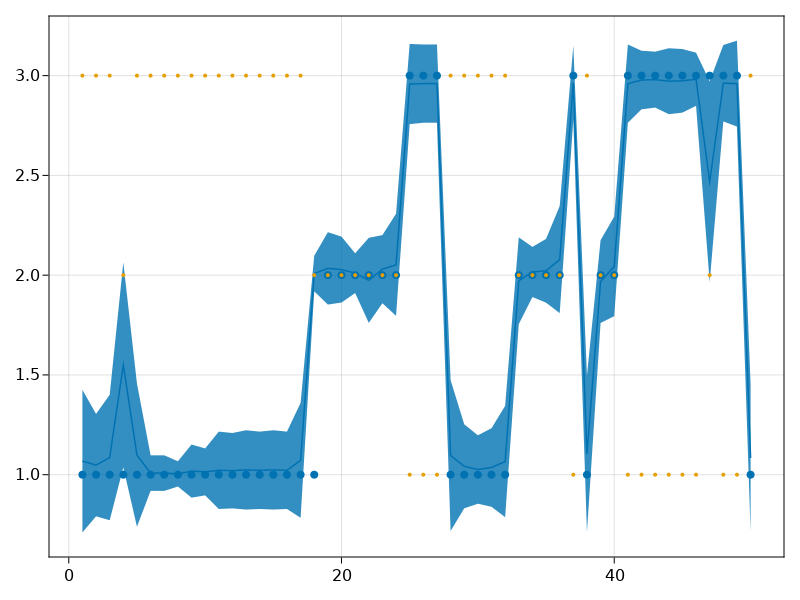

In [14]:
let
    fig = Figure()

    ax = Axis(fig[1, 1])
    
    range = 1:length(z)

    lines!(ax, range, turing_z_means)
    band!(ax, range, turing_z_means .- turing_z_stds, turing_z_means .+ turing_z_stds )
    
    scatter!(ax, range, argmax.(z), markersize = 8, label = "Latent state")
    scatter!(ax, range, argmax.(y), markersize = 4, label = "Observations")

    fig
end

### Benchmarking

In this section we will benchmark inference performance with the help of BenchmarkTools package.

In [19]:
function run_benchmark(params)
    @unpack n, nsamples, seed = params

    # Transition probabilities (some transitions are impossible)
    A = [0.9 0.0 0.1; 0.1 0.9 0.0; 0.0 0.1 0.9] 
    # Observation noise
    B = [0.05 0.05 0.9; 0.05 0.9 0.05; 0.9 0.05 0.05] 
    
    data_params = @strdict n seed A B

    z, y           = generate_data(HMMModel(), data_params)
    chain          = inference_turing(argmax.(y), nsamples = nsamples, seed = seed);
    benchmark      = @benchmark inference_turing(argmax.($y), nsamples = $nsamples, seed = $seed);

    amse = average_mse(z, chain, :z, Distributions.Categorical)
        
    @strdict n nsamples amse seed z y chain benchmark
end

run_benchmark (generic function with 1 method)

In [20]:
benchmark_allparams = dict_list(Dict(
    "n"        => [ 50, 100, 250 ],
    "nsamples" => [ 250, 500 ],
    "seed"     => 42,
));

In [21]:
turing_benchmarks = map(benchmark_allparams) do params
    path = datadir("benchmark", "hmm", "turing")
    result, _ = produce_or_load(path, params, run_benchmark, tag = false)
    return result
end;

┌ Info: File /Users/bvdmitri/.julia/dev/ReactiveMPPaperExperiments/data/benchmark/hmm/turing/n=50_nsamples=250_seed=42.jld2 does not exist. Producing it now...
└ @ DrWatson /Users/bvdmitri/.julia/packages/DrWatson/OgRKj/src/saving_files.jl:61
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:08
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:03
┌ Info: File /Users/bvdmitri/.julia/dev/ReactiveMPPaperExperiments/data/benchmark/hmm/turing/n=50_nsamples=250_seed=42.jld2 saved.
└ @ DrWatson /Users/bvdmitri/.julia/packages/DrWatson/OgRKj/src/saving_files.jl:70
┌ Info: File /Users/bvdmitri/.julia/dev/ReactiveMPPaperExperiments/data/benchmark/hmm/turing/n=50_nsamples=500_seed=42.jld2 does not exist. Producing it now...
└ @ DrWatson /Users/bvd

In [22]:
target_seed = 42
target_nsamples = 500

500

In [23]:
let
    path_smoothing = datadir("benchmark", "hmm", "turing")

    white_list   = [ "n", "nsamples", "seed", "amse" ]
    special_list = [
        :min => (data) -> string(
            round(minimum(data["benchmark"]).time / 1_000_000, digits = 2), "ms"
        ),
        :mean => (data) -> string(
            round(mean(data["benchmark"]).time / 1_000_000, digits = 2), "ms"
        ),
        :gctime => (data) -> string(
            round(minimum(data["benchmark"]).gctime / minimum(data["benchmark"]).time * 100, digits = 2), "%"
        )
    ]

    df_smoothing = collect_results(path_smoothing, 
        white_list = white_list,
        special_list = special_list,
        verbose = false
    )

    query_smoothing = @from row in df_smoothing begin
        @where row.seed == target_seed && row.nsamples == target_nsamples
        @orderby ascending(row.n)
        @select { row.n, row.min, row.gctime, row.amse }
    end

    DataFrame(query_smoothing)
end

┌ Info: Scanning folder /Users/bvdmitri/.julia/dev/ReactiveMPPaperExperiments/data/benchmark/hmm/turing for result files.
└ @ DrWatson /Users/bvdmitri/.julia/packages/DrWatson/OgRKj/src/result_collection.jl:107


,n,min,gctime,amse
,Int64?,String?,String?,Float64?
1,50,132994.51ms,3.06%,14.36
2,100,379222.44ms,5.19%,13.872
3,250,1.83237911e6ms,15.23%,40.67
